In [29]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from numpy.linalg import inv
from scipy import stats
import seaborn as sns
import copy
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")


# Reading in data

In [5]:
#Reading in dem and rep datasets
dem = pd.read_csv('dem_candidates.csv')
cand_summary = pd.read_csv('candidate_summary_2018.csv')
display(dem.head())


,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning data and merging candidate election + financial data

In [6]:
cand_summary = pd.read_csv('candidate_summary_2018.csv')
cand_summary["Cand_Name_split"] = cand_summary["Cand_Name"].str.split(",")
cand_summary.head()

drop_index = []
for i in range(len(cand_summary["Cand_Name_split"])):
    if len(cand_summary["Cand_Name_split"][i]) < 2:
        drop_index.append(i)
drop_index
cand_summary = cand_summary.drop(drop_index)
cand_summary.shape

(3797, 51)

In [7]:
name_series = cand_summary["Cand_Name_split"]

new_name_column = []
for name_list in cand_summary["Cand_Name_split"]:
    name_list_copy = copy.deepcopy(name_list)
    name_list_copy.reverse()
    new_name = name_list_copy[0] + ' ' + name_list_copy[1]
    new_name_column.append(new_name)
new_name_column
cand_summary["New_Cand_Name"] = new_name_column
cand_summary.head()
cand_summary["New_Cand_Name"]= cand_summary["New_Cand_Name"].str.lstrip().str.lower()
cand_summary.head()

,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,...,Other_Committee_Refund,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date,Cand_Name_split,New_Cand_Name
0,https://www.fec.gov/data/candidate/H8TX05052/?...,"ASHBY, KEN",H8TX05052,H,TX,4.0,LIB,CHALLENGER,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN,"[ASHBY, KEN]",ken ashby
1,https://www.fec.gov/data/candidate/S6OH00288/?...,"ECKHART, DON ELIJAH",S6OH00288,S,OH,0.0,REP,CHALLENGER,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN,"[ECKHART, DON ELIJAH]",don elijah eckhart
2,https://www.fec.gov/data/candidate/S8CA00499/?...,"ZIESING, MICHAEL VINCENT",S8CA00499,S,CA,0.0,GRE,CHALLENGER,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN,"[ZIESING, MICHAEL VINCENT]",michael vincent ziesing
3,https://www.fec.gov/data/candidate/H6NJ13191/?...,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,DEM,INCUMBENT,460108.57,596546.56,...,500.0,500.0,98504.05,459357.05,437542.51,290287.08,0.0,01/01/2017,"[SIRES, ALBIO]",albio sires
4,https://www.fec.gov/data/candidate/H6MI03172/?...,"SMITH, DOUGLAS MARK MR. JR.",H6MI03172,H,MI,3.0,IND,CHALLENGER,0.00,3873.60,...,0.0,0.0,0.00,0.00,3873.60,3873.60,0.0,01/01/2017,"[SMITH, DOUGLAS MARK MR. JR.]",douglas mark mr. jr. smith


## Merging data

In [8]:
# Merging

dem["Candidate"] = dem["Candidate"].str.lower()
merged = pd.merge(cand_summary, dem,  how='inner', left_on = 'New_Cand_Name', right_on = 'Candidate')

In [9]:
# Replace missing values

imputer = SimpleImputer(strategy='constant', fill_value='No')
imputed_merged = pd.DataFrame(imputer.fit_transform(merged))
imputed_merged.columns = merged.columns


# Replace yes/no values with 1/0(OHE)

imputed_merged[["Primary %"]] = imputed_merged[["Primary %"]].replace('No', 0)

mapping = {'Yes': 1.0, 'No': 0.0}
imputed_merged.loc[:, "Veteran?": "No Labels Support?"] = imputed_merged.loc[:, "Veteran?": "No Labels Support?"].applymap(mapping.get)

imputed_merged = imputed_merged.drop(columns = ["Link_Image", "Cand_Office", "Cand_Office_Dist", "Cand_Incumbent_Challenger_Open_Seat", "Coverage_End_Date", "Cand_Street_1", "Cand_Street_2", "Cand_City", "Cand_State", "Cand_Zip"])


# Converting ALL demographic features from Veteran? to No Labels Support? and Partisan Lean to float type

imputed_merged[imputed_merged.columns[55:]] = imputed_merged.loc[:, "Veteran?": 'No Labels Support?'].astype("int")
imputed_merged[['Partisan Lean']] = imputed_merged.loc[:, "Partisan Lean"].astype("int")



ex_contr_list = ['Other_Committee_Contribution', 'Party_Committee_Contribution','Individual_Contribution']
total_ex_contribution = imputed_merged[['Other_Committee_Contribution', 'Party_Committee_Contribution','Individual_Contribution']].sum(axis=1)
imputed_merged["Total External Contribution"] = total_ex_contribution.astype("int")

# Contribution Level
med_ex_contr = np.median(imputed_merged[["Total External Contribution"]])

imputed_merged["Contribution Level"] = imputed_merged['Total External Contribution'] > med_ex_contr
imputed_merged.loc[imputed_merged["Contribution Level"] == False,'Contribution Level'] = "Low"
imputed_merged.loc[imputed_merged["Contribution Level"] == True,'Contribution Level'] = "High"
imputed_merged[["Contribution Level"]] = imputed_merged["Contribution Level"]

In [10]:
imputed_merged["Contribution Level"].value_counts()

Low     188
High    187
Name: Contribution Level, dtype: int64

## Visuals for feature selection

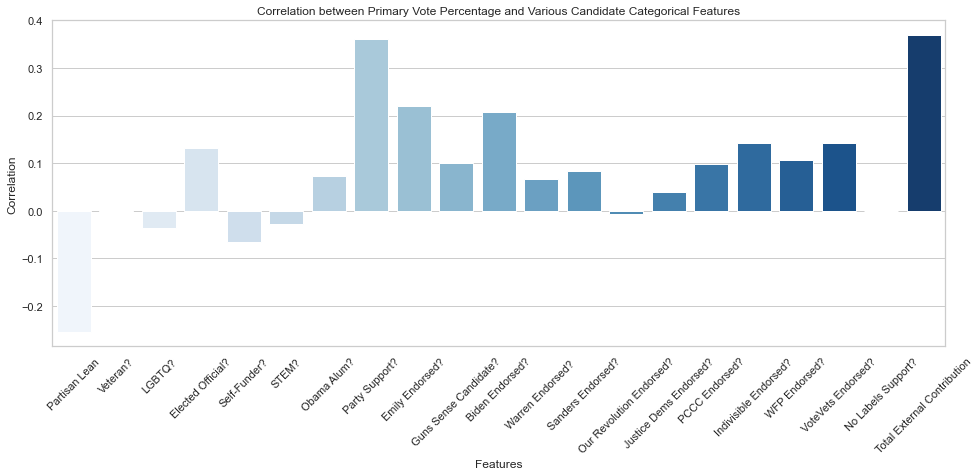

In [11]:
# Correlation between primary % and various variables

plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")
primary_Corr = imputed_merged.corr().loc['Primary %',:]
primary_Corr= primary_Corr.drop(labels=['Primary %'])
ax = sns.barplot(primary_Corr.index, primary_Corr.values,palette="Blues")
plt.xticks(rotation=45)
plt.title("Correlation between Primary Vote Percentage and Various Candidate Categorical Features")
plt.xlabel("Features")
plt.ylabel("Correlation");


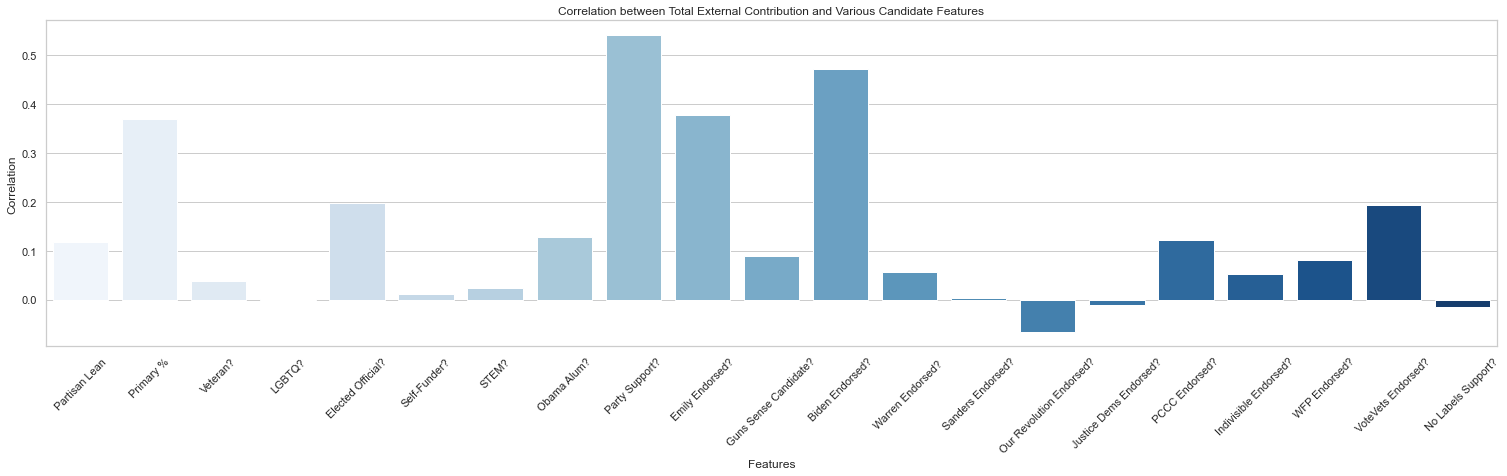

In [12]:
# Correlation between primary % and various variables

plt.figure(figsize=(26, 6))
sns.set_theme(style="whitegrid")
primary_Corr = imputed_merged.corr().loc["Total External Contribution",:]
primary_Corr= primary_Corr.drop(labels=["Total External Contribution"])
ax = sns.barplot(primary_Corr.index, primary_Corr.values,palette="Blues")
plt.xticks(rotation=45)
plt.title("Correlation between Total External Contribution and Various Candidate Features")
plt.xlabel("Features")
plt.ylabel("Correlation");


Low correlation features: LGBTQ?, Self-Funder?, Sanders Endorsed?, Justice Dems Endorsed?, No Labels Support?
We can look into why these may not have a big influence.

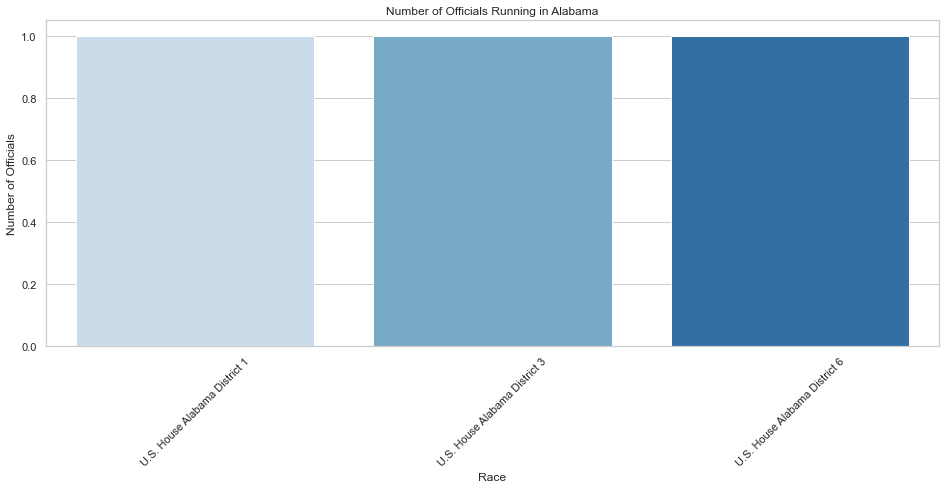

In [13]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")
CAElectionCounts = imputed_merged[imputed_merged['State'] == 'AL'].groupby('District').count()['Candidate']
ax = sns.barplot(CAElectionCounts.index, CAElectionCounts.values,palette="Blues")
plt.xticks(rotation=45)
plt.title("Number of Officials Running in Alabama")
plt.xlabel("Race")
plt.ylabel("Number of Officials");

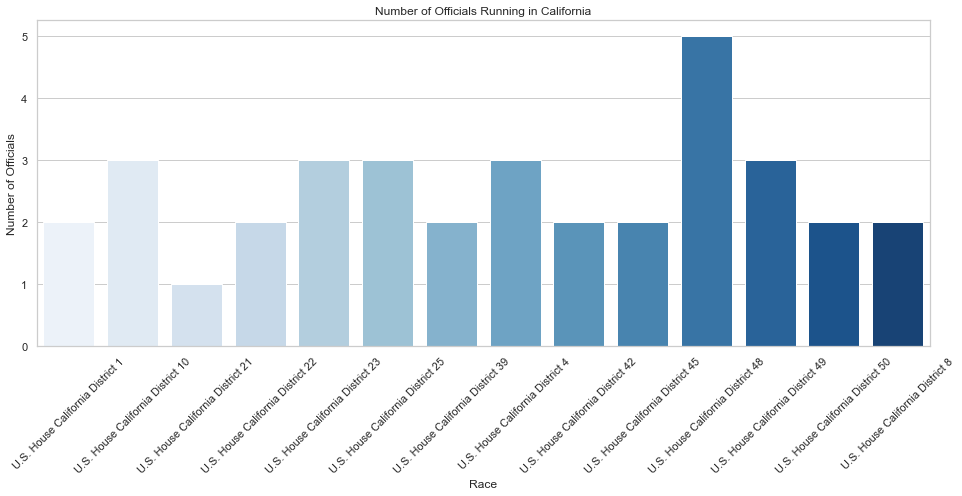

In [14]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")
CAElectionCounts = imputed_merged[imputed_merged['State'] == 'CA'].groupby('District').count()['Candidate']
ax = sns.barplot(CAElectionCounts.index, CAElectionCounts.values,palette="Blues")
plt.xticks(rotation=45)
plt.title("Number of Officials Running in California")
plt.xlabel("Race")
plt.ylabel("Number of Officials");

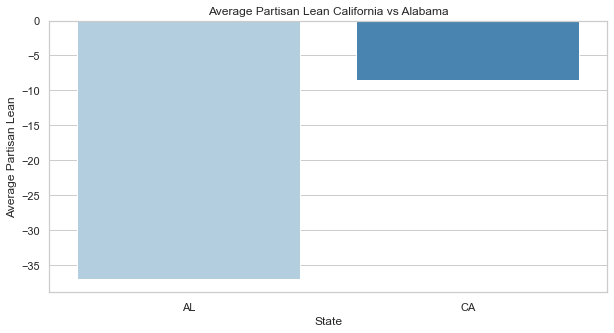

In [15]:
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
CAElectionPartisanLean = imputed_merged.groupby('State').mean().iloc[[0, 3]]
CAElectionPartisanLean
ax = sns.barplot(CAElectionPartisanLean.index, CAElectionPartisanLean['Partisan Lean'],palette="Blues")
plt.title("Average Partisan Lean California vs Alabama")
plt.xlabel("State")
plt.ylabel("Average Partisan Lean");

# Modeling Work

## Train Test Split

In [17]:
# imputed_merged = imputed_merged.drop(columns=["Veteran?", "LGBTQ?", "Self-Funder?", "STEM?", "Sanders Endorsed?", "Justice Dems Endorsed?", "No Labels Support?", "Partisan Lean Categ"])
# imputed_merged

#train/test split
train, test = train_test_split(imputed_merged, test_size = 0.2,random_state = 0) 

In [18]:
#Modeling work
# Predicting partisan lean
# change race to 0 or 1
X_train = train.loc[:, "Veteran?": 'No Labels Support?']
X_train["Partisan Lean"] = train["Partisan Lean"]
y_train = train.loc[:, "Total External Contribution"]
X_test = test.loc[:, "Veteran?": 'No Labels Support?']
X_test["Partisan Lean"] = test["Partisan Lean"]
y_test = test.loc[:, "Total External Contribution"]


## Random Forest Regressor model

In [19]:
#GLM vs rf for predicting external contribution

#Predicting external contribution
# Updated using selected features
# change race to 0 or 1
X_train = train.loc[:, ["Party Support?", "Emily Endorsed?", "Biden Endorsed?"]]
#X_train["Partisan Lean"] = train["Partisan Lean"]
y_train = train.loc[:, "Total External Contribution"]
X_test = test.loc[:, ["Party Support?", "Emily Endorsed?", "Biden Endorsed?"]]
#X_test["Partisan Lean"] = test["Partisan Lean"]
y_test = test.loc[:, "Total External Contribution"]

forest_model = RandomForestRegressor(random_state=0) 
forest_model.fit(X_train, y_train) 


# Scoring Accuracy
print("Accuracy:",forest_model.score(X_test, y_test))

Accuracy: -0.16961519382323598


## GLM Model

In [20]:
X = imputed_merged.loc[:, ["Party Support?", "Emily Endorsed?", "Biden Endorsed?"]].to_numpy().astype(float)
y = imputed_merged["Total External Contribution"].to_numpy().astype(float)

#counting number of zeros in each column
X.astype(bool).sum(axis=0)

array([26, 33,  6])

In [21]:
## Now working with parametric methods: frequentist GLM

import statsmodels.api as sm 

gaussian_model = sm.GLM(
    y, X, 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      2.4919e+12
Method:                          IRLS   Log-Likelihood:                -5882.6
Date:                Mon, 10 May 2021   Deviance:                   9.2699e+14
Time:                        21:33:21   Pearson chi2:                 9.27e+14
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.143e+06   3.59e+05      8.759      0.0

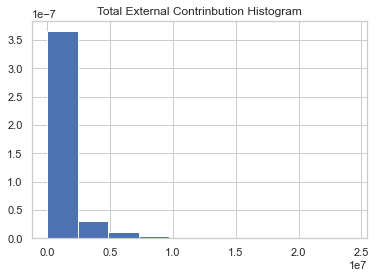

In [22]:
x_axis = imputed_merged["Total External Contribution"].to_numpy()
x_range = range(x_axis.min(), x_axis.max())
plt.hist(x_axis, range=(x_axis.min(), x_axis.max()), density=True)
plt.title("Total External Contrinbution Histogram");

In [23]:
poisson_model = sm.GLM(
    y, X, 
    family=sm.families.Poisson()
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5969e+09
Date:                Mon, 10 May 2021   Deviance:                   5.1938e+09
Time:                        21:33:23   Pearson chi2:                 5.06e+14
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8246      0.000    5.5e+04      0.0

In [24]:
tweedie_model = sm.GLM(
    y, X, 
    family=sm.families.Tweedie()
)
tweedie_results = tweedie_model.fit()
print(tweedie_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                 Tweedie   Df Model:                            2
Link Function:                    log   Scale:                      1.3597e+12
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 10 May 2021   Deviance:                   5.1938e+09
Time:                        21:33:24   Pearson chi2:                 5.06e+14
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8246    293.319      0.047      0.9

In [25]:
binomial_model = sm.GLM(
    y, X, 
    family=sm.families.Binomial()
)
binomial_results = binomial_model.fit()
print(binomial_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 10 May 2021   Deviance:                          inf
Time:                        21:33:25   Pearson chi2:                 5.39e+30
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.415e+22   1.53e+07   9.28e+14      0.0

It looks like Total External Contribution could be modeled using some exponentially decaying function. 

In [26]:
poisson_model = sm.GLM(
    y, X, 
    family=sm.families.Poisson()
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5969e+09
Date:                Mon, 10 May 2021   Deviance:                   5.1938e+09
Time:                        21:33:26   Pearson chi2:                 5.06e+14
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8246      0.000    5.5e+04      0.0

In [27]:
tweedie_model = sm.GLM(
    y, X, 
    family=sm.families.Tweedie()
)
tweedie_results = tweedie_model.fit()
print(tweedie_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                 Tweedie   Df Model:                            2
Link Function:                    log   Scale:                      1.3597e+12
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 10 May 2021   Deviance:                   5.1938e+09
Time:                        21:33:27   Pearson chi2:                 5.06e+14
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            13.8246    293.319      0.047      0.9

In [28]:
binomial_model = sm.GLM(
    y, X, 
    family=sm.families.Binomial()
)
binomial_results = binomial_model.fit()
print(binomial_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 10 May 2021   Deviance:                          inf
Time:                        21:33:27   Pearson chi2:                 5.39e+30
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.415e+22   1.53e+07   9.28e+14      0.0

## Random Forest Classification Model

In [30]:
#Predicting contribution level
# change race to 0 or 1

X_train = train.loc[:, "Veteran?": 'No Labels Support?']
y_train = train.loc[:, "Contribution Level"]
X_test = test.loc[:, "Veteran?": 'No Labels Support?']
y_test = test.loc[:, "Contribution Level"]

forest_model = RandomForestClassifier(random_state=0) 
forest_model.fit(X_train, y_train) 


# Scoring Accuracy
print("Accuracy:",forest_model.score(X_test, y_test))

Accuracy: 0.7333333333333333


In [31]:
forest_model.predict(X_test)

array(['Low', 'High', 'High', 'Low', 'Low', 'Low', 'High', 'Low', 'Low',
       'Low', 'High', 'High', 'High', 'Low', 'Low', 'High', 'High', 'Low',
       'Low', 'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'High',
       'High', 'Low', 'Low', 'High', 'Low', 'High', 'Low', 'Low', 'Low',
       'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'Low', 'Low',
       'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'Low',
       'High', 'High', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low',
       'Low', 'Low', 'High', 'Low', 'Low', 'Low', 'High', 'High', 'High',
       'High', 'High', 'Low', 'High'], dtype=object)

In [32]:
imputed_merged.columns

Index(['Cand_Name', 'Cand_Id', 'Cand_Office_St', 'Cand_Party_Affiliation',
       'Total_Receipt', 'Total_Disbursement', 'Cash_On_Hand_COP',
       'Debt_Owed_By_Committee', 'Individual_Itemized_Contribution',
       'Individual_Unitemized_Contribution', 'Individual_Contribution',
       'Other_Committee_Contribution', 'Party_Committee_Contribution',
       'Cand_Contribution', 'Total_Contribution',
       'Transfer_From_Other_Auth_Committee', 'Cand_Loan', 'Other_Loan',
       'Total_Loan', 'Offsets_To_Operating_Expenditure',
       'Offsets_To_Fundraising', 'Offsets_To_Leagal_Accounting',
       'Other_Receipts', 'Operating_Expenditure',
       'Exempt_Legal_Accounting_Disbursement', 'Fundraising_Disbursement',
       'Transfer_To_Other_Auth_Committee', 'Cand_Loan_Repayment',
       'Other_Loan_Repayment', 'Total_Loan_Repayment', 'Individual_Refund',
       'Party_Committee_Refund', 'Other_Committee_Refund',
       'Total_Contribution_Refund', 'Other_Disbursements', 'Net_Contribution'

## Causal Inference and Simpson's Paradox

### Accounting for Confounding Factor: Number of Competitiors

IDEA: We think if we group by the size of the race each candidate is in, we can get a more accurate ATE. This is because individuals in large races are more likely to have high contribution levels but lower primary candidate %. 

In [33]:
stateCountMap = (imputed_merged.groupby('State').count()['Cand_Name']).to_dict()
imputed_merged['CompetitorCount'] = imputed_merged[["State"]].applymap(stateCountMap.get) 
imputed_merged

,Cand_Name,Cand_Id,Cand_Office_St,Cand_Party_Affiliation,Total_Receipt,Total_Disbursement,Cash_On_Hand_COP,Debt_Owed_By_Committee,Individual_Itemized_Contribution,Individual_Unitemized_Contribution,...,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Total External Contribution,Contribution Level,CompetitorCount
0,"DETERS, BRIAN",H8IL18092,IL,DEM,20583.1,19770.3,812.77,0,8831.1,10735.4,...,0,0,0,0,0,0,0,19766,Low,23
1,"MILLER, DARREL",H4IL18117,IL,DEM,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Low,23
2,"BIGGAN, JOHN",H8TX24111,TX,DEM,86564.6,86564.6,0,0,55885,7443,...,0,0,0,0,0,0,0,67328,Low,44
3,"VALENCIA, PEDRO",H8TX29060,TX,DEM,5598.35,5566.46,31.89,1458.47,862.69,1710.66,...,0,0,0,0,0,0,0,2573,Low,44
4,"GASQUE, DOROTHY",H8WA03172,WA,DEM,88996.7,45068.6,22533.2,0,40990.9,44321.2,...,1,1,0,0,0,0,0,85623,Low,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,"EDWARDS, GREG",H8PA15187,PA,DEM,451975,426514,26460.3,0,213547,222394,...,0,1,1,0,1,0,0,449611,High,27
371,"GREIMEL, TIM",H8MI11338,MI,DEM,1.01868e+06,1.01602e+06,2662.12,0,729187,100141,...,0,0,0,0,0,0,0,1017178,High,21
372,"HORN, KENDRA",H8OK05109,OK,DEM,1.28379e+06,1.18429e+06,99492,39250,963052,214977,...,0,0,0,0,0,0,0,1283785,High,10
373,"ALLRED, COLIN",H8TX32098,TX,DEM,5.97268e+06,5.86923e+06,103445,0,3.86201e+06,1.06454e+06,...,0,0,0,0,0,0,0,5398649,High,44


8.0

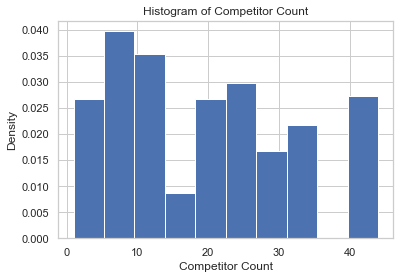

In [34]:
x_axis = imputed_merged['CompetitorCount'].to_numpy()
x_range = range(x_axis.min(), x_axis.max())
plt.hist(x_axis, range=(x_axis.min(), x_axis.max()), density=True);
plt.xlabel('Competitor Count')
plt.ylabel('Density')
plt.title('Histogram of Competitor Count')
np.percentile(x_axis, q=25)

In [35]:
np.percentile(x_axis, q=25), np.percentile(x_axis, q=50), np.percentile(x_axis, q=75), np.percentile(x_axis, q=100)

(8.0, 21.0, 27.0, 44.0)

In [36]:
# Separating data by CompetitorCount to see if Contribution Level affects whether a candidate wins
# the primary differently based on the amount of competitors they have

lostAdvancedMap = {'Yes': 1, 'No': 0}
imputed_merged[['Won Primary']] = imputed_merged[['Won Primary']].applymap(lostAdvancedMap.get).astype('int')

race_size_small = imputed_merged.loc[imputed_merged['CompetitorCount'] <= 8.0]
race_size_medium = imputed_merged.loc[(imputed_merged['CompetitorCount'] > 8.0) & (imputed_merged['CompetitorCount'] <= 21.0)]
race_size_large = imputed_merged.loc[(imputed_merged['CompetitorCount'] > 21.0) & (imputed_merged['CompetitorCount'] <= 27.0)]
race_size_huge = imputed_merged.loc[(imputed_merged['CompetitorCount'] > 27.0)]

In [37]:
def split_XYZ(imputed_merged):
    # Z = treatment, Y = outcome, X = confounders
    imputed_merged.loc[imputed_merged["Contribution Level"] == "High",'Contribution Level'] = 1
    imputed_merged.loc[imputed_merged["Contribution Level"] == "Low",'Contribution Level'] = 0
    imputed_merged[["Contribution Level"]] = imputed_merged["Contribution Level"].astype(int)

    Z = imputed_merged['Contribution Level'].to_numpy()
    Y = imputed_merged['Won Primary']
    X = imputed_merged.loc[:, "Veteran?": 'No Labels Support?'].to_numpy()
    return Z, Y, X

In [38]:
smallZ, smallY, smallX = split_XYZ(race_size_small)
medZ, medY, medX = split_XYZ(race_size_medium)
largeZ, largeY, largeX = split_XYZ(race_size_large)
hugeZ, hugeY, hugeX = split_XYZ(race_size_huge)
Z, Y, X = split_XYZ(imputed_merged)

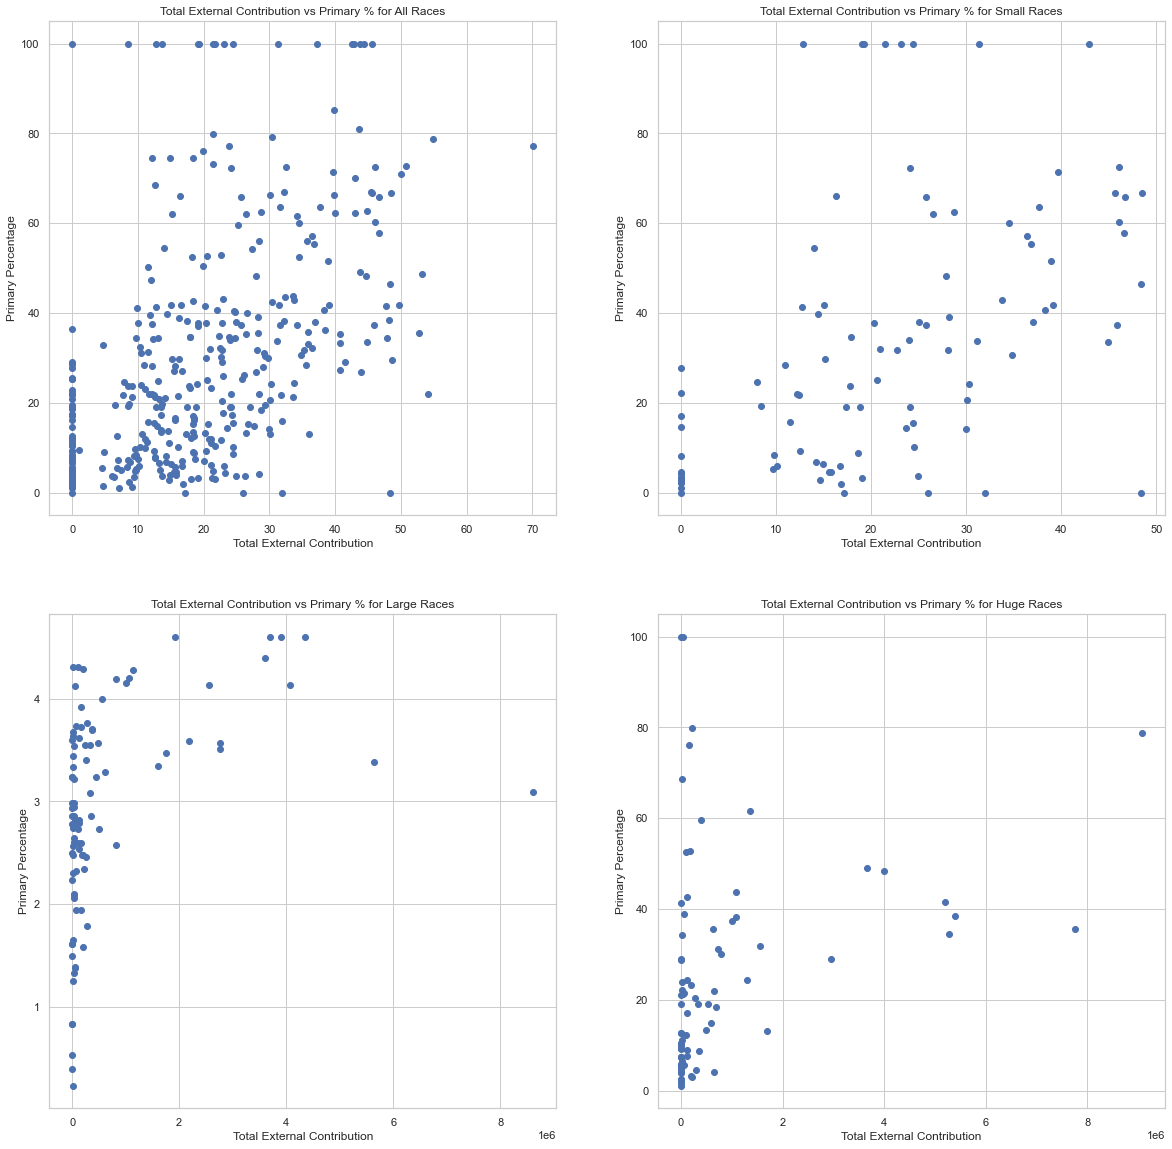

In [40]:
# Looking at subplots of Total External Contribution and its relationship to Primary % to get an idea
# of the magnitude and strength of their relationship based on different race sizes

fig, axs = plt.subplots(2, 2,figsize=(20,20))

axs[0,0].scatter(np.sqrt(np.sqrt(imputed_merged['Total External Contribution'])), imputed_merged['Primary %'])
axs[0,0].set_title('Total External Contribution vs Primary % for All Races')
axs[0,0].set_xlabel('Total External Contribution')
axs[0,0].set_ylabel('Primary Percentage')
axs[0,1].scatter(np.sqrt(np.sqrt(race_size_small['Total External Contribution'])), race_size_small['Primary %'])
axs[0,1].set_title('Total External Contribution vs Primary % for Small Races')
axs[0,1].set_xlabel('Total External Contribution')
axs[0,1].set_ylabel('Primary Percentage')
axs[1,0].scatter(race_size_large['Total External Contribution'], np.log(race_size_large['Primary %']))
axs[1,0].set_title('Total External Contribution vs Primary % for Large Races')
axs[1,0].set_xlabel('Total External Contribution')
axs[1,0].set_ylabel('Primary Percentage')
axs[1,1].scatter(race_size_huge['Total External Contribution'], race_size_huge['Primary %'])
axs[1,1].set_title('Total External Contribution vs Primary % for Huge Races')
axs[1,1].set_xlabel('Total External Contribution')
axs[1,1].set_ylabel('Primary Percentage');

Based on these plots, there seems to be a somewhat positive relationship between Total External Contribution and Primary Percentage for various race sizes

## Causal Inference Analysis

### ATE

In [41]:
# Initializing Logistic Regression models for various race sizes

from sklearn.linear_model import LogisticRegression as LR
lr0 = LR(penalty='none', max_iter=200, random_state=0)
lr1 = LR(penalty='none', max_iter=200, random_state=0)
lr2 = LR(penalty='none', max_iter=200, random_state=0)
lr3 = LR(penalty='none', max_iter=200, random_state=0)
lr4 = LR(penalty='none', max_iter=200, random_state=0)

In [42]:
fitted_all = lr0.fit(X, Z)
fitted_small = lr1.fit(smallX, smallZ)
fitted_med = lr2.fit(medX, medZ)
fitted_large = lr3.fit(largeX, largeZ)
fitted_huge = lr4.fit(hugeX, hugeZ)

In [43]:
def treatment_effect(lr, X, Y, Z):
    t = lr.predict_proba(X)[:, 1]
    val = np.mean(Z * Y / t) - np.mean((1 - Z) * Y / (1 - t))
    return val

In [44]:
estimate_all = treatment_effect(lr0, X, Y, Z)
estimate_small = treatment_effect(lr1, smallX, smallY, smallZ)
estimate_med = treatment_effect(lr2, medX, medY, medZ)
estimate_large = treatment_effect(lr3, largeX, largeY, largeZ)
estimate_huge = treatment_effect(lr4, hugeX, hugeY, hugeZ)

In [45]:
# Estimating the Average Treatment Effect of high Total External Contribution level for all races, small races,
# medium races, large races, and huge races

estimate_all, estimate_small, estimate_med, estimate_large, estimate_huge

(0.4182091375066609,
 0.4364760855567319,
 0.35499676510932676,
 0.47109948094930265,
 0.13731138593585548)

The ATEs are all positive, it seems a high contribution level does cause more wins. 